# Machine Learning in a Nutshell with scikit-learn
    
## Unsupervised Learning: Clustering


by [__Michael Granitzer__ (michael.granitzer@uni-passau.de)]( http://www.mendeley.com/profiles/michael-granitzer/) and [Konstantin Ziegler (konstantin.ziegler@uni-passau.de)](http://zieglerk.net) based on examples from the [scikit-learn documentation](http://scikit-learn.org/stable/)

__License__

This work is licensed under a [CC BY 3.0](http://creativecommons.org/licenses/by/3.0/)


## Outline

1. Overview
2. Partition-based, iterative Clustering - K-Means
3. Hierarchical Agglomerative Clustering - Ward
4. Density based Clustering - DBSCAN
5. Clustering text documents

# Overview

Unsupervised learning aims to find latent structures in data. 

* **Dimensionality Reduction** aims to project points from a high-dimensional space into a low-dimensional space
* **Clustering** identifies groups of similar data samples. The objective is to maximize intra group similarity and mininmize intergroup similarity.
* **Manifold Learning** aims to indentify lower-dimensional subspaces that contain a particular structure of data samples

In this notebook, we cover the basic applications with scikit-learn. For the underlying theory and more, see the references at the end of this page.

## Clustering


**Clustering**: Group $n$ data samples into $k$ clusters such that the similarity among samples **within a cluster is maximized** and the similarity **between cluster is minimized** .

## Input Data

In scikit-learn, input to a clustering can take two different forms:

1. As a matrix consisting of `n_samples` and `n_features`
2. As a similarity (distance/dissimilarity) matrix of shape `[n_samples, n_samples]`

Given a **similarty measure** or **distance metric** between samples, the first approach can always be converted in the second approach. 


## Overview of clustering methods in scikit-learn

The following image gives an overview over scikit learn methods.

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png">

Image taken from [scikit-learn](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html). You can find the generating code under `modules/plot_cluster_comparison.py`.

# Data

In [32]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets as sklearn_datasets
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

seed = 42
np.random.seed(seed)

#create 3 normally distributed clusters 
n_points = 100
normal2D_X = np.array(np.random.randn(n_points,2))*2+1
normal2D_X = np.append(normal2D_X, np.random.randn(n_points, 2)*3+10,axis=0)
normal2D_X = np.append(normal2D_X, np.random.randn(n_points, 2)*1-3,axis=0)
normal2D_y = [0] * n_points + [1] * n_points + [2] * n_points

# create 3 uniform distributed clusters
n_points = 100
uniform2D_X = np.array(np.random.ranf((n_points, 2))*2+1)
uniform2D_X = np.append(uniform2D_X ,np.random.ranf((n_points, 2))*3+3,axis=0)
uniform2D_X = np.append(uniform2D_X ,np.random.ranf((n_points, 2))*1-3,axis=0)
uniform2D_y = [0] * n_points + [1] * n_points + [2] * n_points

# generate blobs (normally distributed)
centers = [[1, 1], [-1, -1], [1, -1]]
blobs_X, blobs_y = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=seed)
# rescale to mean 0 and variance 1
blobs_X = StandardScaler().fit_transform(blobs_X)

# generate nested
moons_X, moons_y = sklearn_datasets.make_moons(500, noise=0.20)

# Load IRIS dataset (3 types of flowers)
iris = sklearn_datasets.load_iris()
print(iris['DESCR'])
iris_X = iris.data
iris_y = iris.target

# Load MNIST Digits dataset (10 digits)
digits = sklearn_datasets.load_digits(n_class=10)
print(digits['DESCR'])
digits_X = digits.data
digits_y = digits.target
n_samples, n_features = digits_X.shape

datasets = {
    'normal2D': (normal2D_X, normal2D_y),
    'uniform2D': (uniform2D_X, uniform2D_y),
    'blobs': (blobs_X, blobs_y),
    'moons': (moons_X, moons_y),
    'iris': (iris_X, iris_y),
    'digits': (digits_X, digits_y)
}

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

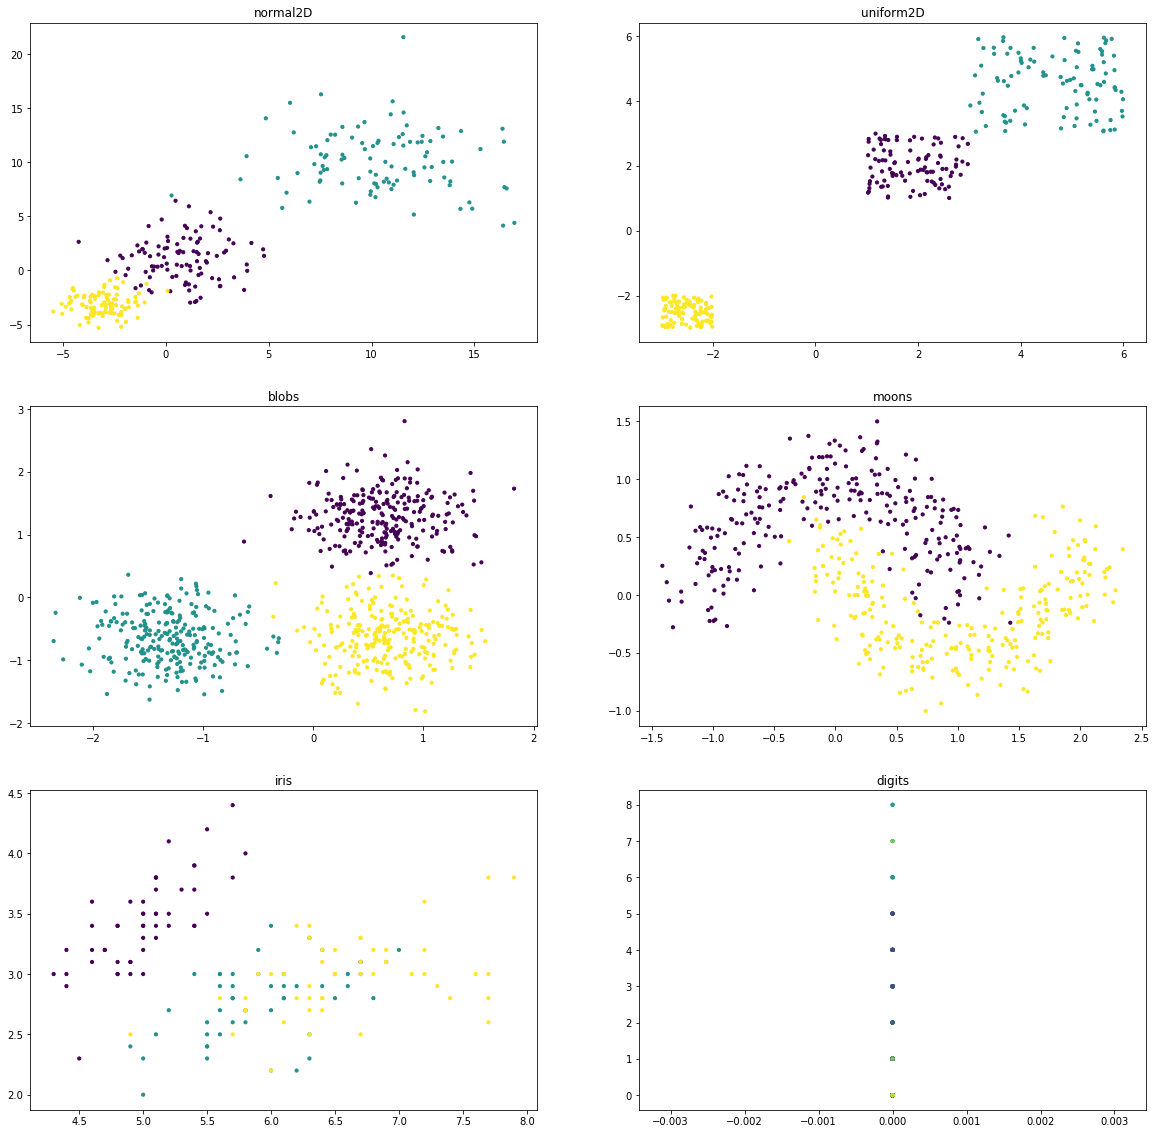

In [2]:
plt.figure(figsize=(20,20))
for i, d in enumerate(datasets):
    data_X, data_y = datasets[d]
    plt.subplot(len(datasets)//2,2,i+1)
    plt.title(d)
    plt.scatter(data_X[:,0], data_X[:,1], c=data_y, s=10)
plt.show()

# How to plot 64-dim points in 2D?

With dimensionality reduction techniques we can project points from a high-dimensional space to a low-dimensional space. The projection map should be chosen such that relative distances are preserved under the map. Only then can we reason about the structure of the data when looking at its low-dim projection. 

A low-dimensional projection will not exactly preserve the relative distances, because there are not enough degrees of freedom to lay out all points. However, even though we get only an approximation of the relative distances it is oftentimes beneficial:
- estimate of the data density (be careful with non-linear techniques)
- noise suppression
- computational efficiency (for stacking later on)

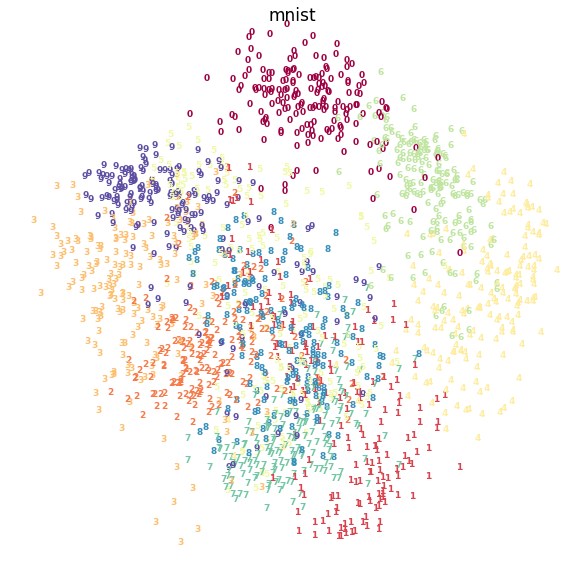

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_dataset_predictions(X, y, predictions=None, title=None, proj=PCA):
    ''' Visualize data, ground-truth and predictions '''
    
    if X.shape[1] > 2:
        X = proj(n_components=2).fit_transform(X)
        
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    X = (X - x_min) / (x_max - x_min)
    
    colors = plt.cm.Spectral(np.zeros(len(X)))
    if predictions is not None:
        c_r = max(predictions)
        colors = plt.cm.Spectral(predictions / float(c_r))

    plt.figure(figsize=(8, 8))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=colors[i], fontdict={'weight': 'bold', 'size': 9})

    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()
    return X
    

#plot_dataset_predictions(moons_X, moons_y, predictions=None, title='nested')
#plot_dataset_predictions(iris_X, iris_y, predictions=None, title='iris')
X_red = plot_dataset_predictions(digits_X, digits_y, predictions=digits_y, title='mnist', proj=PCA)

# K-Means Clustering

In this exercise we develop and apply the k-means algorithm and evaluate it visually on the digits dataset created above.

k-means is an iterative, partitioning-based clustering algorithm that minimizes

$$J(\mathcal{S}) = \sum_{i}^k \sum_{x_j \in S_i} || x_j - \mu_i ||^2$$

with samples $x_j$, $k$ cluster representatives $C = \{\mu_i\}$ and the induced partitioning $\mathcal{S} = \{S_i\}$.

It searches for a set of clusters that minimize the squared distances of all data points to the cluster representatives. In case of k-**means** a cluster representative is the mean of the cluster's data points.

### Algorithm Sketch

1. **Initalise** $C$ by selecting $k$ cluster representatives $\mu_1 \ldots \mu_k$
2. **Partition** the data according to the cluster representatives, i.e. assign $x_j$ to the cluster $argmin_{\mu_i\in \{\mu_1 \ldots \mu_k\}}(||x_j-\mu_i||^2) $
3. **Recalculate** the cluster representatives $\mu_1 \ldots \mu_k$ as $\mu_i=\frac{1}{|S_i|}\sum_{x_j \in S_i}x_j$
4. If the partition does not change or a number of iteration is exceeded, stop. Otherwise go to 2.

### Some Algorithmic Properties

* k-means is very sensitive to the starting points $\mu_i$
* k-means needs to know the number of clusters a-priori
* k-means can be applied on one sample per iteration (i.e. assignment and recalculation per sample), which is called online (or stochastic) k-means. Going over all samples before recalculating the representatives is called (full-)batch. There a differences in convergence rate and stopping criterion.
* k-means finds only cluster of approximately similar size that induce a [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram)
* k-means assumes spherical clusters
<a href="http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html" target="_blank"><img src="https://pythonprogramming.net/static/images/unsupervised-learning/plot_kmeans_digits_001.png"></a>
(image from scikit Learn. You can find the generating code under `modules/plot_kmeans_digits.py`)

In [18]:
data = np.random.randn(1000, 2)

def choose_centroids(X, k):
    _X = X.copy()
    np.random.shuffle(_X)
    return _X[:k]

def find_nearest_centroids(X, centroids, fast=True):
    if not fast:
        closest_centroid = []
        for x in X:
            dists_to_centroids = []
            for mu in centroids:
                d = np.sqrt(np.sum((x - mu)**2.))
                dists_to_centroids.append(d)
            i = np.argmin(dists_to_centroids)
            closest_centroid.append(i)
        return np.array(closest_centroid)
    else:
        _d = np.sqrt(np.sum((X[:, np.newaxis] - centroids)**2., axis=-1))
        return np.argmin(_d, axis=1)
    # return a list of length X.shape[0]
    # Each element in the list corresponds to the index of the closest cluster an example should be assigned to.

def update_centroids(X, centroids, nearest_centroids):
    new_centroids = []
    for k, c in enumerate(centroids):
        _X_within_Ck = X[nearest_centroids == k]
        new_centroid = np.mean(_X_within_Ck, axis=0)
        new_centroids.append(new_centroid)
    return np.vstack(new_centroids)

/home/schloetter/anaconda3/envs/datsci18/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


Stopping after 29 iterations due to convergence.
CPU times: user 12.9 s, sys: 19.9 ms, total: 12.9 s
Wall time: 1.7 s


array([[0.47575032, 0.8468859 ],
       [0.62235562, 0.11679353],
       [0.60699552, 0.30455761],
       ...,
       [0.66758656, 0.3565789 ],
       [0.41828839, 0.69318842],
       [0.49030537, 0.58798322]])

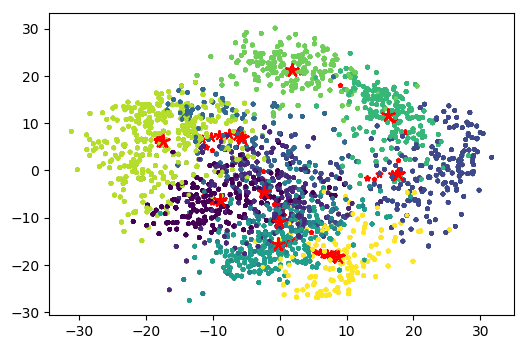

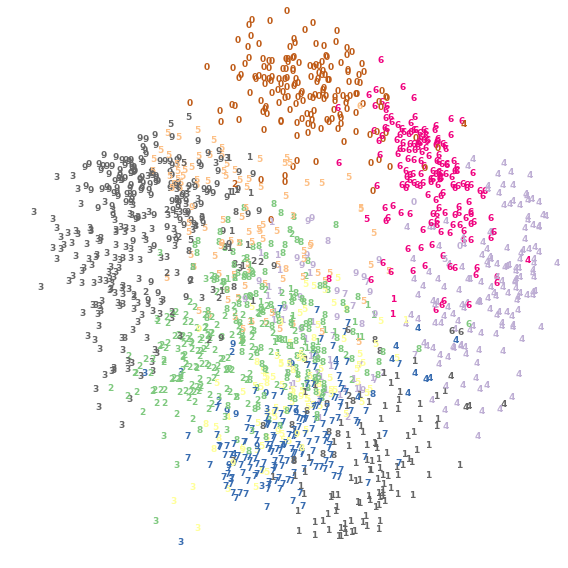

In [19]:
plt.ion()
fig, ax = plt.subplots(dpi=100)
fig.show()
fig.canvas.draw()

def do_KMeans(X, k, n_iter_max=100, plot_interval=2):
    
    # Only for visualization purposes
    data_proj = PCA(n_components=2).fit(X)

    c = 0
    cluster_assigment_old = np.array([-1] * X.shape[0])
    
    # STEP 1 : Pick initial centroids
    centroids = choose_centroids(X, k)
    
    # Iterate k-Means n_iter_max-times
    while c < n_iter_max:
        
        # STEP 2: Find the closest centroid (its index) for each example
        cluster_assignment = find_nearest_centroids(X, centroids)

        # Stop iterating if cluster assignment did not change
        if np.all(cluster_assignment == cluster_assigment_old):
            print("Stopping after %d iterations due to convergence." % c)
            return centroids, cluster_assignment
        
        # STEP 3: Update centroids: new centroid position = mean over examples that have been assigned to this centroid
        centroids = update_centroids(X, centroids, cluster_assignment)
        
        cluster_assigment_old = cluster_assignment
        c += 1
        
        # Fancy plotting every now and then (only with %matplotlib notebook)
        if c % plot_interval == 0:
            _X = data_proj.transform(X)
            _c = data_proj.transform(centroids)
            ax.scatter(_X[:, 0], _X[:, 1], c=cluster_assignment, s=5)
            ax.scatter(_c[:, 0], _c[:, 1], c='r', marker=(5, 2), s=c * (300./n_iter_max))
            fig.canvas.draw()
             
    return centroids, cluster_assignment_old

data_X, data_y = datasets['digits']
%time k_means, pred = do_KMeans(data_X, 10)
plot_dataset_predictions(data_X, data_y, pred)

### Usage in scikit-learn

* Module: `from sklearn.cluster import KMeans`
* Instantiate a object `kmeans = KMeans(....parameters...)`
* Fit to data: `model = kmeans.fit(data)`
* Assign data to cluster: `model.predict (data)`

CPU times: user 308 ms, sys: 0 ns, total: 308 ms
Wall time: 49.8 ms


array([[0.4757503 , 0.84688591],
       [0.62235552, 0.11679356],
       [0.60699556, 0.30455758],
       ...,
       [0.66758659, 0.35657894],
       [0.41828827, 0.69318829],
       [0.49030547, 0.58798323]])

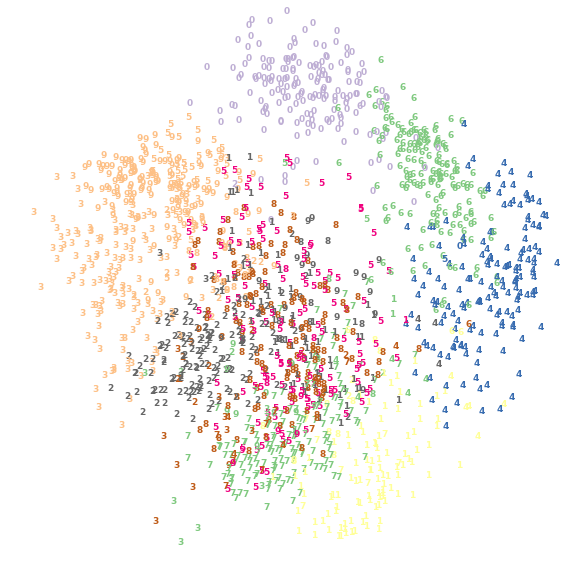

In [20]:
from sklearn.cluster import KMeans

data_X, data_y = datasets['digits']

clustering = KMeans(init='k-means++', n_clusters=10, n_init=1)
%time pred = clustering.fit_predict(data_X)
plot_dataset_predictions(data_X, data_y, pred)

CPU times: user 1.74 s, sys: 40 µs, total: 1.74 s
Wall time: 1.74 s


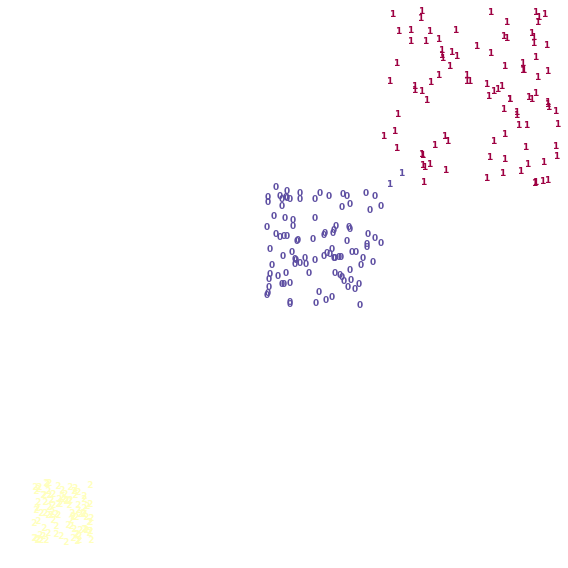

In [16]:
data_X, data_y = datasets['uniform2D']

clustering = KMeans(init='k-means++', n_clusters=3, n_init=2000)
%time pred = clustering.fit_predict(data_X)
x_red = plot_dataset_predictions(data_X, data_y, pred)

# Hierarchical Agglomerative Clustering

* Hierarchical Agglomerative Clustering forms a family of clustering algorithms that build hierarchically nested clusters
* The resulting tree is called a dendrogram
* Agglomerative means bottom up:
  - First, all data points form a single cluster
  - Second, nearest clusters are merged until only one cluster remains
* Critical is the distance measure between clusters (i.e. group of data samples)

### Usage in scikit-learn

Scikit implements the Hierarchical Agglomerative Clustering as follows.
* Module: `from sklearn.cluster import AgglomerativeClustering`
* Instantiate a object `clustering = AgglomerativeClustering(....parameters...)`
* Fit to data: `model = clustering.fit(data)`
* (Optional) Assign new data to cluster: `model.predict(data)`

The possible parameters for distance measure between the clusters are
- linkage='ward': Ward Criterion for variance-minimization of clusters
- linkage='average': average of distances between two sets
- linkage='complete': maximum of distances between two sets

Scikit also allows to add connectivity constraints, i.e. that cluster only merge with certain other samples. This can be helpful for image clustering when limiting clusters to form homogeneous regions in the image

### Using HAC for Image Clustering

Below, you find code to examine the effect of linkage options for HAC, taken from [Ward Demo on the scikit-learn homepage](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html). (Author: Gael Varoquaux, License: BSD 3 clause (C) INRIA 2014) It uses the [Digits Database](http://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) which contains ~1800 images (8x8) of digits with associated labels.

* Run the code below and try to understand what happens. (Several parts are merely dedicated to improving the presentation. First of all, you want to identify the part where the clustering takes place.)

complete : 0.33s
average : 0.31s
ward : 0.34s


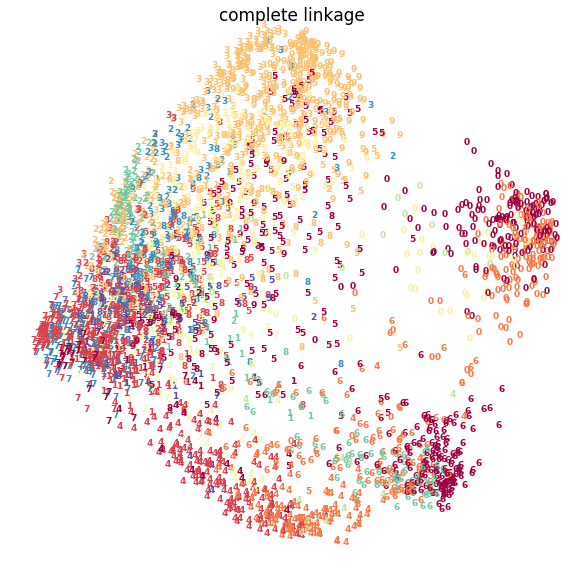

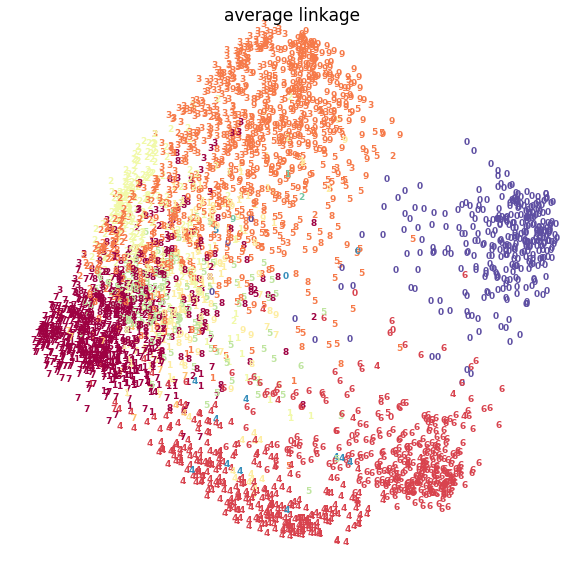

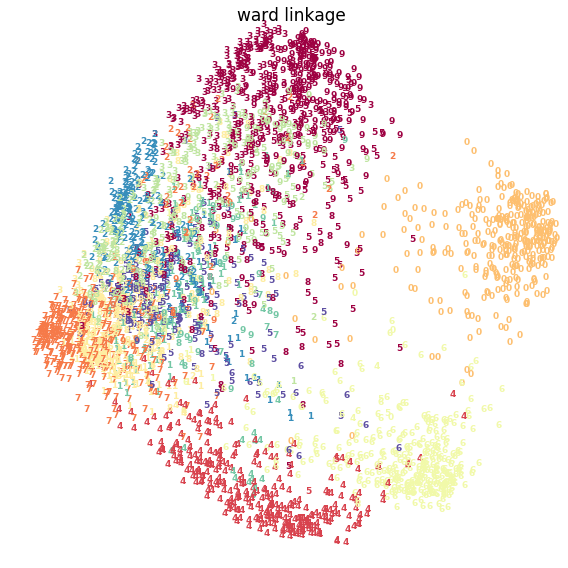

In [25]:
from sklearn.cluster import AgglomerativeClustering

from time import time
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn import manifold


def nudge_images(X, y):
    # Having a larger dataset shows more clearly the behavior of the
    # methods, but we multiply the size of the dataset only by 2, as the
    # cost of the hierarchical clustering methods are strongly
    # super-linear in n_samples
    shift = lambda x: ndimage.shift(x.reshape((8, 8)),
                                  .3 * np.random.normal(size=2),
                                  mode='constant',
                                  ).ravel()
    X = np.concatenate([X, np.apply_along_axis(shift, 1, X)])
    Y = np.concatenate([y, y], axis=0)
    return X, Y


digits_X_l, digits_y_l = nudge_images(digits_X, digits_y)

for linkage in ('complete', 'average', 'ward'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(digits_X_l)
    print("%s : %.2fs" % (linkage, time() - t0))
    X_red = plot_dataset_predictions(digits_X_l, digits_y_l, clustering.labels_, title="%s linkage" % linkage, proj=manifold.SpectralEmbedding)
    #X_red = plot_labeled_dataset(digits_X_l, digits_y_l, clustering.labels_, "%s linkage" % linkage, proj=manifold.SpectralEmbedding)


# DBScan - Density-based Clustering

* Density-based Clustering aims to find regions of high density that are separated via regions of low density.
* DBScan differentiates between noise points, core points and border points by defining an $\epsilon$ environment around a point $x_i$ in which a certain number of points must exists so that $x_i$ qualifies as core point
* Border points can be ambiguos, i.e. can belong to two differnt clusters where they fall in the $\epsilon$ region (but do not form a core point)

#### Usage in scikit learn

* Module: `from sklearn.cluster import DBSCAN`
* Instantiate a object `clustering = DBSCAN(....parameters...)`
* Fit to data: `model = clustering.fit(data)`

The implementation of the algorithm is non-deterministic, i.e. it is dependent on the order of the data. Core points of a cluster will be always assigned to the same cluster, but the cluster number might change depending which cluster core point is taken first.



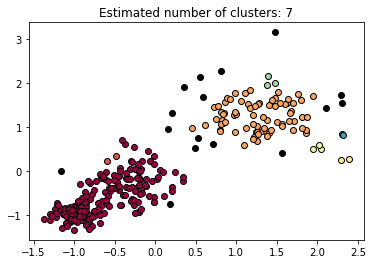

In [34]:
from sklearn.cluster import DBSCAN

def plot_dbscan(X, y, labels):
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # Black removed and is used for noise instead.
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_samples_mask[clustering.core_sample_indices_] = True
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', c=col, markeredgecolor='k')

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', c=col, markeredgecolor='k')

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()


data_X, data_y = datasets['normal2D']
data_X -= data_X.mean(axis=0)
data_X /= data_X.std()
# normal2D: 0.1, 2
# digits : e=5, ms=3
clustering = DBSCAN(eps=0.2, min_samples=2).fit(data_X)
labels = clustering.labels_

plot_dbscan(data_X, data_y, labels)
#X_red = plot_labeled_dataset(digits_X, digits_y, labels, "%s linkage" % linkage, proj=manifold.SpectralEmbedding)
#X_red = plot_dataset_predictions(data_X, data_y, labels, title="DBSCAN", proj=PCA)


# Clustering of text documents

## Data Set
The 20 Newsgroups data set is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups. The data is organized into 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale / soc.religion.christian). Here is a list of the 20 newsgroups, partitioned (more or less) according to subject matter:




<table border=1>
<tr>
<td>comp.graphics<br>comp.os.ms-windows.misc<br>comp.sys.ibm.pc.hardware<br>comp.sys.mac.hardware<br>comp.windows.x</td>
<td>rec.autos<br>rec.motorcycles<br>rec.sport.baseball<br>rec.sport.hockey</td>
<td>sci.crypt<br>sci.electronics<br>sci.med<br>sci.space</td>
</tr><tr>
<td>misc.forsale</td>
<td>talk.politics.misc<br>talk.politics.guns<br>talk.politics.mideast</td>
<td>talk.religion.misc<br>alt.atheism<br>soc.religion.christian</td>
</tr>
</table>

The "bydate"-option is sorted by date into training(60%) and test(40%) sets, does not include cross-posts (duplicates) and does not (should not) include newsgroup-identifying headers (Xref, Newsgroups, Path, Followup-To, Date). 

In [35]:
# shell scripts for downloading the data and placing it in a corresponding directory
!mkdir newsgroups
!curl -o newsgroups/news.tar.gz "http://qwone.com/~jason/20Newsgroups/20news-bydate.tar.gz"
# extract the files
!gzip -d < newsgroups/news.tar.gz | tar xf - --directory newsgroups

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.7M  100 13.7M    0     0  4298k      0  0:00:03  0:00:03 --:--:-- 4297k


In [36]:
!ls newsgroups/
print('--------------------------------')
!ls newsgroups/20news-bydate-train/
print('--------------------------------')
!ls newsgroups/20news-bydate-train/alt.atheism/
print('--------------------------------')
!less newsgroups/20news-bydate-train/alt.atheism/49960

20news-bydate-test  20news-bydate-train  news.tar.gz
--------------------------------
alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc
misc.forsale		  sci.med
--------------------------------
49960  51164  51212  51258  51305  53094  53158  53210	53284  53439  53660
51060  51165  51213  51259  51306  53095  53159  53211	53285  53440  53661
51119  51169  51214  51260  51307  53096  53160  53212	53286  53441  53753
51120  51170  51215  51261  51308  53097  53161  53213	53287  53442  53754
51121  51171  51216  51262  51309  53098  53162  53214	53288  53443  53755
51122  51172  51217  51265  51310  53099  53163  53215	53289  53445  53756
51123  51173  51218  51266  51311  53106  53164  53216	53

In [37]:
from sklearn.datasets import load_files

twenty_train = load_files('./newsgroups/20news-bydate-train/', encoding='latin1')
twenty_test = load_files('./newsgroups/20news-bydate-test/', encoding='latin1')

In [38]:
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfTransformer

vectorizer = feature_extraction.text.CountVectorizer()
transformer = TfidfTransformer()

vectorizer.fit(twenty_train.data)

train_counts = vectorizer.transform(twenty_train.data)
test_counts = vectorizer.transform(twenty_test.data)

transformer.fit(train_counts)

X_train = transformer.transform(train_counts)
X_test = transformer.transform(test_counts)

#print(X_train[0])
#print(train_counts.shape)
#print(train_counts[0])

In [45]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD

X = TruncatedSVD(n_components=10).fit_transform(X_train)
clustering = KMeans(init='k-means++', n_clusters=6, n_init=10)
#clustering = DBSCAN(eps=0.08, min_samples=20)
#clustering = AgglomerativeClustering(linkage='ward', n_clusters=6)
%time pred = clustering.fit_predict(X)

CPU times: user 2.85 s, sys: 4.02 ms, total: 2.85 s
Wall time: 373 ms


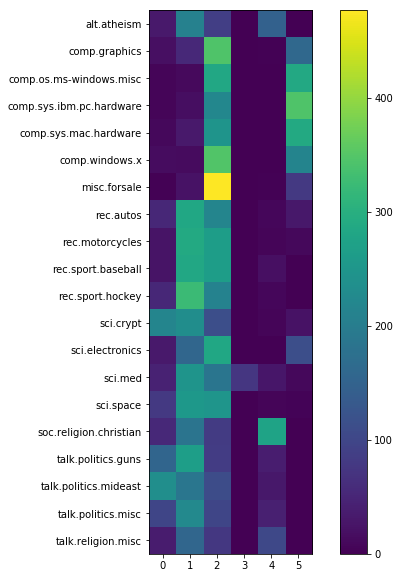

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import contingency_matrix

labels_true = twenty_train.target
labels_pred = pred

C = contingency_matrix(twenty_train.target, pred, eps=None, sparse=False)

plt.figure(figsize=(10,10))
plt.imshow(C, interpolation='nearest')
plt.xticks(range(C.shape[1]))
locs, labels = plt.yticks(range(C.shape[0]), twenty_train.target_names)
plt.colorbar()

# Clustering Evaluation

The quality of clustering has to be measured, otherwise results can be abritrary (especially for high dimensional data where visualisation of clusters is not possible)

Cluster quality measure can be distinguished between

2. **External Validity Indices** that rely on a given correct assignment of points to groups
1. **Internal Validity Indices** that indicate the quality of the shape of an cluster without relying on the correct assignment of points to cluster

These measures are often used for finding the best parameters in a **relative validation**.

### Realisation in scikit-learn

Scikit learn implements a number of validity measures. See [the tutorial](http://scikit-learn.org/stable/modules/clustering.html#clustering) for an overview. 


## Adjusted Rand Index

In [47]:
from sklearn import metrics

y = [0, 0, 0, 1, 1, 1]
p = [0, 0, 1, 1, 2, 2]
#p = [1, 1, 0, 0, 3, 3] # Ignores permutations of assignments [1, 1, 0, 0, 3, 3] and relabeling

metrics.adjusted_rand_score(y, p)  

0.24242424242424246

# Mutual information

In [50]:
from sklearn import metrics

y = [0, 0, 0, 1, 1, 1]
p = [0, 0, 1, 1, 2, 2]
#p = [1, 1, 0, 0, 3, 3] # Ignores permutations of assignments [1, 1, 0, 0, 3, 3] and relabeling
 
metrics.adjusted_mutual_info_score(y, p) 

0.2250422831983088

# Silhouette Coefficient

If the ground truth labels are not known, evaluation must be performed using the model itself. The Silhouette Coefficient is an example of such an evaluation, where a higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:

- a: The mean distance between a sample and all other points in the same class.
- b: The mean distance between a sample and all other points in the next nearest cluster.

The Silhouette Coefficient s for a single sample is then given as:

$$s = \frac{b - a}{\max(a,b)}$$

0.5528190123564091

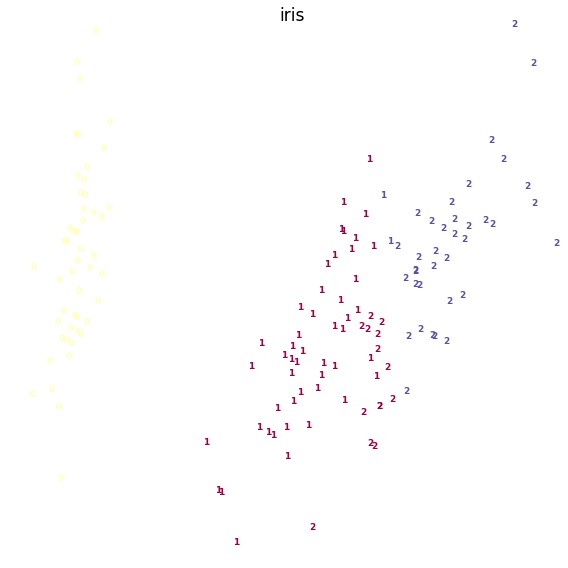

In [51]:
d = 'iris'
data_X, data_y = datasets[d]
kmeans_model = KMeans(n_clusters=3, random_state=1).fit(data_X)
p = kmeans_model.labels_
plot_dataset_predictions(data_X, data_y, p, d)

metrics.silhouette_score(data_X, p, metric='euclidean')

# What is it good for?

- Inspection (e.g. similarity between samples, customer groups)
- Abstraction (e.g. efficient coding, representatives vs. individuals, cold-start problem)

# Further References and Reading

- [Lecture Notes on the Course Machine Learning and Data Mining](http://www.uni-weimar.de/en/media/chairs/webis/teaching/lecturenotes/#machine-learning). 
- Pang-Ning Tan, Michael Steinbach, and Vipin Kumar, [Introduction to Data Mining](http://www.pearsonhighered.com/educator/academic/product/0,1144,0321321367,00.html), Addison-Wesley, 2006. ISBN 0-321-32136-7. 
- [Unsupervised learning: seeking representations of the data](http://scikit-learn.org/stable/tutorial/statistical_inference/unsupervised_learning.html), scikit-learn Tutorial.


### Precision and Recall

For a given class with label `a`, we can compute the precision and recall of our prediction.
- True Positives (TP): In the set of examples for which we predicted `a`, how many were in fact labeled `a`?
- False Positives (FP): In the set of examples for which we predicted `a`, how many were in fact not labeled `a`?
- True Negatives (TN): In the set of examples for which we did not predict `a`, how many were in fact not labeled `a`?
- False Negatives (FN): In the set of examples for which we did not predict `a`, how many were in fact labeled `a`?

$$Precision = \frac{TP}{TP+FP}$$
$$Recall = \frac{TP}{TP+FN}$$

$$FScore = 2 * \frac{Precision * Recall}{Precision + Recall}$$

In [52]:
from sklearn import metrics
y = [0, 1, 0, 1, 1, 1]
p = [0, 1, 1, 1, 0, 1]

pr, re, fs, su = metrics.precision_recall_fscore_support(y, p, warn_for=())
clustering_score = metrics.fowlkes_mallows_score(y, p)
print("Precisions:", pr)
print("Recalls:", re)
print("F-Scores:", fs)
print("Support:", su)
print("FMS:", clustering_score)

Precisions: [0.5  0.75]
Recalls: [0.5  0.75]
F-Scores: [0.5  0.75]
Support: [2 4]
FMS: 0.4285714285714285
